# Fibonacci sequence with LangGraph
## Reminder :
- F0 = 0  
- F1 = 1 
- Fn = Fn-1 + Fn-2

## Calculation with a State Machine :

```
States (Nodes):
Initial State (Start): The starting state before any calculation begins.
currentState = Start
a = 0
b = 1
counter = 0

while (currentState != End) {
    if (currentState == Start) {
        currentState = Calculate
    } else if (currentState == Calculate) {
        display a
        next_termTerm = a + b
        if (counter >= n) {
            currentState = End
        } else {
            currentState = Update
        }
    } else if (currentState == Update) {
        a = b
        b = next_termTerm
        counter = counter + 1
        currentState = Calculate
    }
}
```

## State machine implementation with LangGraph :

In [1]:
from typing import Literal, TypedDict

from IPython.display import Image
from langchain_core.runnables import chain
from langgraph.graph import END, StateGraph
from rich import print  # noqa: F401


class State(TypedDict, total=False):
    """State of the calculation.
    'total=False' because LangGraph allows that only the fields that have changed can be returned.
    """

    a: int
    b: int
    next_term: int
    counter: int
    sequence: list[int]
    n: int


workflow = StateGraph(State)


@chain
def init_node(_: State) -> State:
    return {"a": 0, "b": 1, "counter": 0, "sequence": [0, 1]}


@chain
def calculate_node(state: State) -> State:
    next_term = state["a"] + state["b"]
    return {
        "next_term": next_term,
        "sequence": state["sequence"] + [next_term],
    }


@chain
def next_state(state: State) -> Literal["update", "finish"]:
    if state["counter"] < state["n"]:
        return "update"
    else:
        return "finish"


@chain
def update_node(state: State) -> State:
    return {
        "a": state["b"],
        "b": state["next_term"],
        "counter": state["counter"] + 1,
    }


# Define the graph
workflow.add_node("init", init_node)
workflow.add_node("calculate", calculate_node)
workflow.add_node("update", update_node)

workflow.set_entry_point("init")
workflow.add_edge("init", "calculate")
workflow.add_conditional_edges(
    "calculate",
    next_state,
    {
        "update": "update",
        "finish": END,
    },
)
workflow.add_edge("update", "calculate")


app = workflow.compile()

In [2]:
# Test...
out = app.invoke({"n": 5})
print(out["sequence"])

[0, 1, 1, 2, 3, 5, 8, 13]

In [ ]:
out

In [3]:
#  Test in streaming (correct missing initial values if you want..=
for output in app.stream({"n": 10}, {"recursion_limit": 30}):
    for key, value in output.items():
        if key == "calculate":
            print(value["next_term"], end=" ")

1

2

3

5

8

13

21

34

55

89

144

In [4]:
print(app.get_graph().draw_ascii())

+-----------+          
        | __start__ |          
        +-----------+          
               *               
               *               
               *               
           +------+            
           | init |            
           +------+            
               *               
               *               
               *               
        +-----------+          
        | calculate |          
        +-----------+          
          .        *           
        ..          **         
       .              *        
+---------+        +--------+  
| __end__ |        | update |  
+---------+        +--------+

Look at https://python.langchain.com/v0.2/docs/how_to/lcel_cheatsheet/  for more.

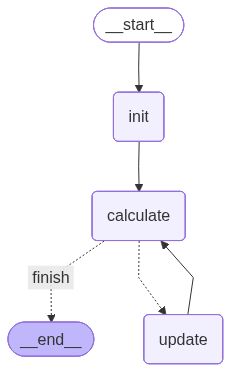

In [5]:
img = app.get_graph().draw_mermaid_png()
Image(img)

## Graph display with Graphviz (optional)
Need graphviz and pygraphviz installed  <br>
```code
    sudo apt-get install graphviz graphviz-dev
    uv add pygraphviz


### Exercise : 
- Check that 'n' is greater than 1, else print a message.
    - hint: use ```workflow.set_conditional_entry_point(...  ```
- Have a and b as parameter of the chain . For example, calculate  Lucas Numbers (a=2, b=1, 3, 4, 7, 11, 18, 29,....)

#  Texte en Gras

- liste 1
- liste 2